In [1]:
%matplotlib widget

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".95"
os.environ["CUDA_HOME"] = "/usr/local/cuda-12.6"
os.environ["CUPY_NVRTC_INCLUDE_DIR"] = "/usr/local/cuda-12.6/include"
os.environ["PATH"] = os.environ["CUDA_HOME"] + "/bin:" + os.environ.get("PATH", "")
os.environ["LD_LIBRARY_PATH"] = os.environ["CUDA_HOME"] + "/lib64:" + os.environ.get("LD_LIBRARY_PATH", "")

import abtem
import ase
from ase.cluster import Octahedron, Decahedron
from ase.build import bulk, surface
from ase.visualize import view
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np

from pathlib import Path
import sys
# add parent folder (and common src folder) to sys.path so imports can be resolved
parent = Path.cwd().parent
candidates = [parent, parent / "src"]
for p in candidates:
    if p.exists() and str(p) not in sys.path:
        sys.path.insert(0, str(p))


from wide_angle_propagation import (
    energy2wavelength, 
    fresnel_propagation_kernel, 
    simulate_fresnel_as,
    simulate_wpm,
    )

abtem.config.set({"device": "gpu"})
abtem.config.set({"precision": "float32"})
jax.config.update("jax_enable_x64", True)


In [ ]:
import numpy as np
import abtem
from ase.build import bulk, surface

# -----------------------
# 1) Crystal: Si(111)
# -----------------------
a = 5.431  # Å
si = bulk("Si", "diamond", a=a)

# (111)-oriented repeat; no vacuum
slab = surface(si, (1, 1, 1), layers=6, vacuum=0.0)
slab = abtem.orthogonalize_cell(slab)
slab.pbc = (True, True, True)

# -----------------------
# 2) Match their k-window + grid:
#    256 px over ~5.12 Å^-1 => L ~ 50 Å
# -----------------------
target_xy = 50.0    # Å
target_z  = 1500.0  # Å (150 nm)

Lx, Ly, Lz = slab.cell.lengths()
nx = int(np.ceil(target_xy / Lx))
ny = int(np.ceil(target_xy / Ly))
nz = int(np.ceil(target_z  / Lz))

atoms = slab * (nx, ny, nz)
atoms.pbc = (True, True, False)  # finite thickness along beam
atoms.center(axis=2)

# -----------------------
# 3) Frozen lattice configs (paper: <u^2>=0.0045 Å^2)
# -----------------------
sigma = np.sqrt(0.0045)  # Å
slice_thickness_A = 4.7  # Å (paper nominal slice thickness)

def make_potential(num_configs):
    frozen = abtem.FrozenPhonons(
        atoms,
        num_configs=num_configs,
        sigmas=sigma,
        directions="xyz",
        ensemble_mean=True,
        seed=0,
    )
    pot = abtem.Potential(
        frozen,
        gpts=(512, 512),
        slice_thickness=slice_thickness_A,
        parametrization="lobato",
        projection="finite",
        periodic=True,
    )
    return pot

# -----------------------
# 4) Probe: disk touches (220)
# -----------------------
alpha_mrad = 6.6
probe = abtem.Probe(energy=200e3, semiangle_cutoff=alpha_mrad, soft=0.0, tilt=(0.0, 0.0))

# Paper mentions an absorption-treatment cutoff around 33 nm^-1 (~84 mrad at 200 keV).
det_max_angle_mrad = 90.0
det = abtem.PixelatedDetector(max_angle=det_max_angle_mrad)

In [3]:
import numpy as np
import matplotlib.pyplot as plt



def to_intensity(meas, gamma=0.15):
    """Return 2D float intensity array and angular extent in mrad."""
    if getattr(meas, "is_lazy", False):
        meas = meas.compute()

    arr = meas.array  # abTEM measurements expose raw data via .array
    if getattr(meas, "is_complex", False):
        I = np.abs(arr) ** 2
    else:
        I = np.asarray(arr)

    # Normalize + power-law like the paper
    I = I / (I.max() + 1e-30)
    I = I ** gamma

    # Scattering angle coordinates in mrad (works for DiffractionPatterns)
    if hasattr(meas, "angular_coordinates"):
        ax_mrad, ay_mrad = meas.angular_coordinates  # (x, y)
        extent = [ax_mrad.min(), ax_mrad.max(), ay_mrad.min(), ay_mrad.max()]
    else:
        extent = None

    # abTEM arrays often use (x,y) axis order; matplotlib expects (y,x) image.
    # Transpose for correct orientation when using imshow.
    return I.T, extent



In [6]:
num_frozen_configs = 32
pot = make_potential(num_configs=num_frozen_configs)
probe.grid.match(pot)
dp = probe.multislice(pot, detectors=det)
dp = dp.compute() 


tasks:   0%|          | 0/130 [00:00<?, ?it/s]

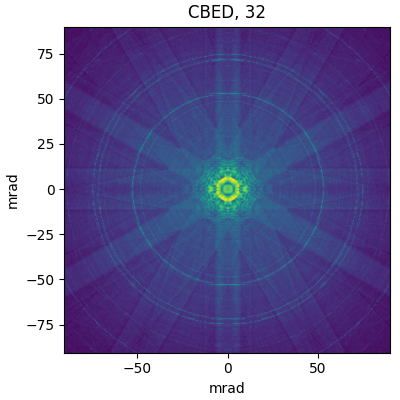

In [7]:
I_power_law, extent = to_intensity(dp, gamma=0.15)
I_lin = np.abs(dp.array) ** 2 / np.max(np.abs(dp.array) ** 2) # linear intensity, normalized to max for display
fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
ax.imshow(I_power_law, extent=extent, origin="lower", aspect="equal")
ax.set_xlabel("mrad")
ax.set_ylabel("mrad")
ax.set_title(f"CBED, {num_frozen_configs}")

plt.show()


In [ ]:
# Extract sampling as separate values to ensure proper type handling
sampling_x, sampling_y = probe.grid.sampling[0], probe.grid.sampling[1]

fresnel_propagator = fresnel_propagation_kernel(
    probe.grid.gpts[0],
    probe.grid.gpts[1],
    (sampling_x, sampling_y),  # Pass as tuple explicitly
    z=slice_thickness,
    energy=probe.energy,
)

# Call updated library function with energy and return_wavefronts
exit_wave_fresnel, diffraction_pattern_fresnel, _ = simulate_fresnel_as(
    potential_array, probe_array, fresnel_propagator, slice_thickness, 
    energy
)


In [ ]:
exit_wave_wpm_binning, diffraction_pattern_wpm_binning, _ = simulate_wpm(
    potential_array, probe_array, slice_thickness, energy, (sampling_x, sampling_y), n_bins=64
)

In [ ]:
plt.figure()
plt.imshow(np.angle(exit_wave_fresnel) ** 2, origin='lower')

## Slice-by-slice Comparison: Fresnel vs WPM binning
The plots below show cross-sections (center row) of the wavefronts for each slice. Intensities are normalized to the same global maximum so differences are directly comparable. Phases are wrapped to [-π, π].


In [ ]:
cols = 3
fig, ax = plt.subplots(2, cols, figsize=(cols * 3, 8))

# Use existing cross-section stacks (shape: [slice, x])
wf_fresnel_cs = np.asarray(wavefronts_fresnel)[:, wavefronts_fresnel.shape[1]//2, :]
wf_wpm_bin_cs = np.asarray(wavefronts_wpm_binning)[:, wavefronts_wpm_binning.shape[1]//2, :]

# Intensities
intensity_fresnel = np.abs(wf_fresnel_cs) ** 2
intensity_wpm_bin = np.abs(wf_wpm_bin_cs) ** 2

# Global normalization across the two methods
all_max = max(
    intensity_fresnel.max(),
    intensity_wpm_bin.max(),
)
global_max = all_max if all_max > 0 else 1.0

intensity_fresnel = (intensity_fresnel / global_max).astype(np.float32)
intensity_wpm_bin = (intensity_wpm_bin / global_max).astype(np.float32)

# Intensity difference: WPM binning - Fresnel
intensity_diff = intensity_wpm_bin - intensity_fresnel

# Phases
phase_fresnel = np.angle(wf_fresnel_cs)
phase_wpm_bin = np.angle(wf_wpm_bin_cs)

# Phase difference wrapped to [-pi, pi]
def wrap_phase_diff(a, b):
    return (a - b + np.pi) % (2 * np.pi) - np.pi

phase_diff = wrap_phase_diff(phase_wpm_bin, phase_fresnel)

# Intensity plotting (row 0)
vmax_int = 1.0
im_fresnel = ax[0, 0].imshow(intensity_fresnel, aspect='auto', origin='upper', vmin=0.0, vmax=vmax_int, cmap='viridis')
ax[0, 0].set_title("Fresnel Intensity")
ax[0, 0].set_ylabel("Slice Index")
fig.colorbar(im_fresnel, ax=ax[0, 0], label="Normalized intensity")

im_wpm_bin = ax[0, 1].imshow(intensity_wpm_bin, aspect='auto', origin='upper', vmin=0.0, vmax=vmax_int, cmap='viridis')
ax[0, 1].set_title("WPM binning Intensity")
fig.colorbar(im_wpm_bin, ax=ax[0, 1], label="Normalized intensity")

# Intensity difference colormap limits (symmetric)
vmax_diff = np.max(np.abs(intensity_diff))
vmax_diff = vmax_diff if vmax_diff > 0 else 1.0

im_diff = ax[0, 2].imshow(intensity_diff, aspect='auto', origin='upper', cmap='bwr', vmin=-vmax_diff, vmax=vmax_diff)
ax[0, 2].set_title("Intensity Diff (WPM binning - Fresnel)")
fig.colorbar(im_diff, ax=ax[0, 2], label="Diff (norm)")

# Phase plotting (row 1)
vmin_phase, vmax_phase = -np.pi, np.pi
p_fresnel = ax[1, 0].imshow(phase_fresnel, aspect='auto', origin='upper', cmap='twilight', vmin=vmin_phase, vmax=vmax_phase)
ax[1, 0].set_title("Fresnel Phase")
ax[1, 0].set_xlabel("X Position")
ax[1, 0].set_ylabel("Slice Index")
fig.colorbar(p_fresnel, ax=ax[1, 0], label="Phase (rad)")

p_wpm_bin = ax[1, 1].imshow(phase_wpm_bin, aspect='auto', origin='upper', cmap='twilight', vmin=vmin_phase, vmax=vmax_phase)
ax[1, 1].set_title("WPM binning Phase")
ax[1, 1].set_xlabel("X Position")
fig.colorbar(p_wpm_bin, ax=ax[1, 1], label="Phase (rad)")

# Phase differences
im_diff_phase = ax[1, 2].imshow(phase_diff, aspect='auto', origin='upper', cmap='twilight', vmin=vmin_phase, vmax=vmax_phase)
ax[1, 2].set_title("Phase Diff (WPM binning - Fresnel)")
ax[1, 2].set_xlabel("X Position")
fig.colorbar(im_diff_phase, ax=ax[1, 2], label="Diff (rad)")

plt.tight_layout()



## Exit Wave & Diffraction Pattern: Fresnel vs WPM binning
Exit waves and diffraction patterns are normalized per-image to the range [0,1] for display. Differences use a symmetric diverging colormap.


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

# helper to fetch available variable names (tries several common names)
def _get(*names):
    for n in names:
        if n in globals():
            return np.asarray(globals()[n])
    raise NameError(f"None of the names found: {names}")

# get wavefronts
ew_f = _get("exit_wave_fresnel", "wf_fresnel", "wavefronts_fresnel")
ew_wb = _get("exit_wave_wpm_binning", "wf_wpm_binning", "wavefronts_wpm_binning")

# get diffraction patterns
dp_f = _get("diffraction_pattern_fresnel", "dp_f")
dp_wb = _get("diffraction_pattern_wpm_binning", "dp_wb")

# layout: 2 rows x 3 columns
fig, axs = plt.subplots(2, 3, figsize=(14, 8))

# colorbar helper
def add_colorbar(ax, im, size="4%", pad=0.05, **kwargs):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=size, pad=pad)
    return fig.colorbar(im, cax=cax, **kwargs)

# normalize helper
def norm01(x):
    x = np.asarray(x)
    m = x.max() if x.max() != 0 else 1.0
    return (x / m).astype(np.float32)

# --- Row 1: Exit Wave Amplitude (Fresnel, WPM binning, Diff) ---
ew_f_n = norm01(np.abs(ew_f))
ew_wb_n = norm01(np.abs(ew_wb))

diff_ew = (ew_wb_n - ew_f_n) * 100
vmax_ew = np.max(np.abs(diff_ew)) if np.max(np.abs(diff_ew)) > 0 else 1.0

im = axs[0, 0].imshow(ew_f_n, origin="lower", vmin=0.0, vmax=1.0, cmap="viridis")
axs[0, 0].set_title("Exit Wave Amplitude (Fresnel)")
add_colorbar(axs[0, 0], im, label="Normalized Amplitude")

im = axs[0, 1].imshow(ew_wb_n, origin="lower", vmin=0.0, vmax=1.0, cmap="viridis")
axs[0, 1].set_title("Exit Wave Amplitude (WPM binning)")
add_colorbar(axs[0, 1], im, label="Normalized Amplitude")

im = axs[0, 2].imshow(diff_ew, cmap="bwr", origin="lower", vmin=-vmax_ew, vmax=vmax_ew)
axs[0, 2].set_title("Exit Wave Diff (WPM binning - Fresnel)")
add_colorbar(axs[0, 2], im, label="Difference (%)")

# --- Row 2: Diffraction Pattern Amplitude (Fresnel, WPM binning, Diff) ---
# Force reciprocal-space window to 51.2 x 51.2 nm^-1 to match the paper
k_window = 51.2  # nm^-1
extent = [-k_window / 2, k_window / 2, -k_window / 2, k_window / 2]
unit_label = "nm$^{-1}$"

dp_f_n = norm01(np.abs(dp_f))
dp_wb_n = norm01(np.abs(dp_wb))

diff_dp = (dp_wb_n - dp_f_n) * 100
vmax_dp = np.max(np.abs(diff_dp)) if np.max(np.abs(diff_dp)) > 0 else 1.0

# Use LogNorm to visualize the high dynamic range of diffraction patterns
im = axs[1, 0].imshow(dp_f_n, origin="lower", cmap="magma", extent=extent)
axs[1, 0].set_title("Diffraction Pattern (Fresnel)")
axs[1, 0].set_xlabel(f"kx ({unit_label})")
axs[1, 0].set_ylabel(f"ky ({unit_label})")
add_colorbar(axs[1, 0], im, label="Amplitude (Log scale)")

im = axs[1, 1].imshow(dp_wb_n, origin="lower", cmap="magma", extent=extent)
axs[1, 1].set_title("Diffraction Pattern (WPM binning)")
axs[1, 1].set_xlabel(f"kx ({unit_label})")
axs[1, 1].set_ylabel(f"ky ({unit_label})")
add_colorbar(axs[1, 1], im, label="Amplitude (Log scale)")

im = axs[1, 2].imshow(diff_dp, cmap="bwr", origin="lower", vmin=-vmax_dp, vmax=vmax_dp, extent=extent)
axs[1, 2].set_title("Diffraction Diff (WPM binning - Fresnel)")
axs[1, 2].set_xlabel(f"kx ({unit_label})")
axs[1, 2].set_ylabel(f"ky ({unit_label})")
add_colorbar(axs[1, 2], im, label="Difference (%)")

plt.tight_layout()
fig.savefig("fresnel_vs_wpm_2d_maps.pdf", dpi=300)

# --- Additional: Cross-section plot of diffraction patterns and their difference (center row) ---
try:
    center_row = dp_f_n.shape[0] // 2
    x = np.linspace(extent[0], extent[1], dp_f_n.shape[1])
    xlabel_cs = f"Angle ({unit_label})"

    fig_cs, ax_cs = plt.subplots(1, 2, figsize=(12, 3.5))

    # scale helper
    def scale_to_range(a, lo=0.2, hi=0.8):
        a = np.asarray(a, dtype=np.float64)
        amin = a.min()
        amax = a.max()
        if amax <= amin:
            return np.full_like(a, (lo + hi) / 2.0)
        a_norm = (a - amin) / (amax - amin)
        return (a_norm * (hi - lo) + lo).astype(np.float32)

    # center-row profiles (scale intensities to [0.2, 0.8])
    sf = scale_to_range(intensity_fresnel[center_row, :])
    sw = scale_to_range(intensity_wpm_bin[center_row, :])

    ax = ax_cs[0]
    ax.plot(x, sf, label="Fresnel (scaled)", lw=1)
    ax.plot(x, sw, label="WPM binning (scaled)", lw=1)
    ax.set_title("Diffraction center-row cross-section (scaled 0.2–0.8)")
    ax.set_xlabel(xlabel_cs)
    ax.set_ylabel("Scaled Intensity")
    ax.legend(loc="upper right", fontsize="small")

    # differences (percent) of scaled profiles
    ax = ax_cs[1]
    ax.plot(x, (sw - sf) * 100, label="WPM binning - Fresnel (scaled)", lw=1)
    ax.axhline(0, color="k", lw=0.5)
    ax.set_title("Center-row difference (percent)")
    ax.set_xlabel(xlabel_cs)
    ax.set_ylabel("Difference (%)")
    ax.legend(loc="upper right", fontsize="small")

    plt.tight_layout()
    fig_cs.savefig("fresnel_vs_wpm_cross_sections.pdf", dpi=300)
except Exception as e:
    print("Failed to plot diffraction cross-section:", e)
